# DataJoint Elements for Miniscope Calcium Imaging

#### Open source data pipeline for managing and analyzing functional calcium imaging data acquired with UCLA Miniscopes.

Welcome to the tutorial for the DataJoint Element for Miniscope Calcium Imaging. This
tutorial aims to provide a comprehensive understanding of the open-source data pipeline
created using `element-miniscope`. 

The package is designed to seamlessly process, ingest, and track miniscope data
including scan-level metadata, image processing, and curation results across subjects
and sessions. By the end of this tutorial you will have a clear grasp on setting up and
integrating `element-miniscope` into your specific research projects and your lab.


![flowchart](https://raw.githubusercontent.com/datajoint/element-miniscope/main/images/flowchart.svg)

### Prerequisites

Please see the [datajoint tutorials GitHub
repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before
proceeding.

A basic understanding of the following DataJoint concepts will be beneficial to your
understanding of this tutorial: 
1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method. 

#### **Tutorial Overview**

+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* subject and session metadata.
+ *Populate* scan-level (recording-level) metadata.
+ Run image processing using
   [`CaImAn`](https://github.com/flatironinstitute/CaImAn).
+ Curate the results (optional).
+ Visualize the results.

### **Setup**

This tutorial examines data from a UCLA miniscope recording acquired using the Miniscope
DAQ V4. The goal is to extract fluorescence and deconvolved activity traces and use
these traces to study neuronal calcium dynamics and neural activity during
specific behaviors or tasks.

The results of this Element can be combined with **other modalities** to create a
complete, customizable data pipeline for your specific lab or study. For instance, you
can combine `element-miniscope` with `element-calcium-imaging` or `element-deeplabcut`
to characterize neural activity along with markerless pose-estimation during behavior.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

If the tutorial is run in Codespaces, a private, local database server is created and
made available for you. This is where we will insert and store our processed results.
Let's connect to the database server.

In [2]:
dj.conn()

[2023-11-29 17:31:30,218][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-11-29 17:31:30,228][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial activates the `miniscope.py` module from `element-miniscope`, along with
upstream depedencies from `element-animal` and `element-session`. Please refer to the
[`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code. 

In [3]:
from tutorial_pipeline import lab, subject, session, miniscope

[2023-11-29 17:31:33,493][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `miniscope` schema as well as some of the upstream
dependencies to `session` and `subject` schemas as a diagram.

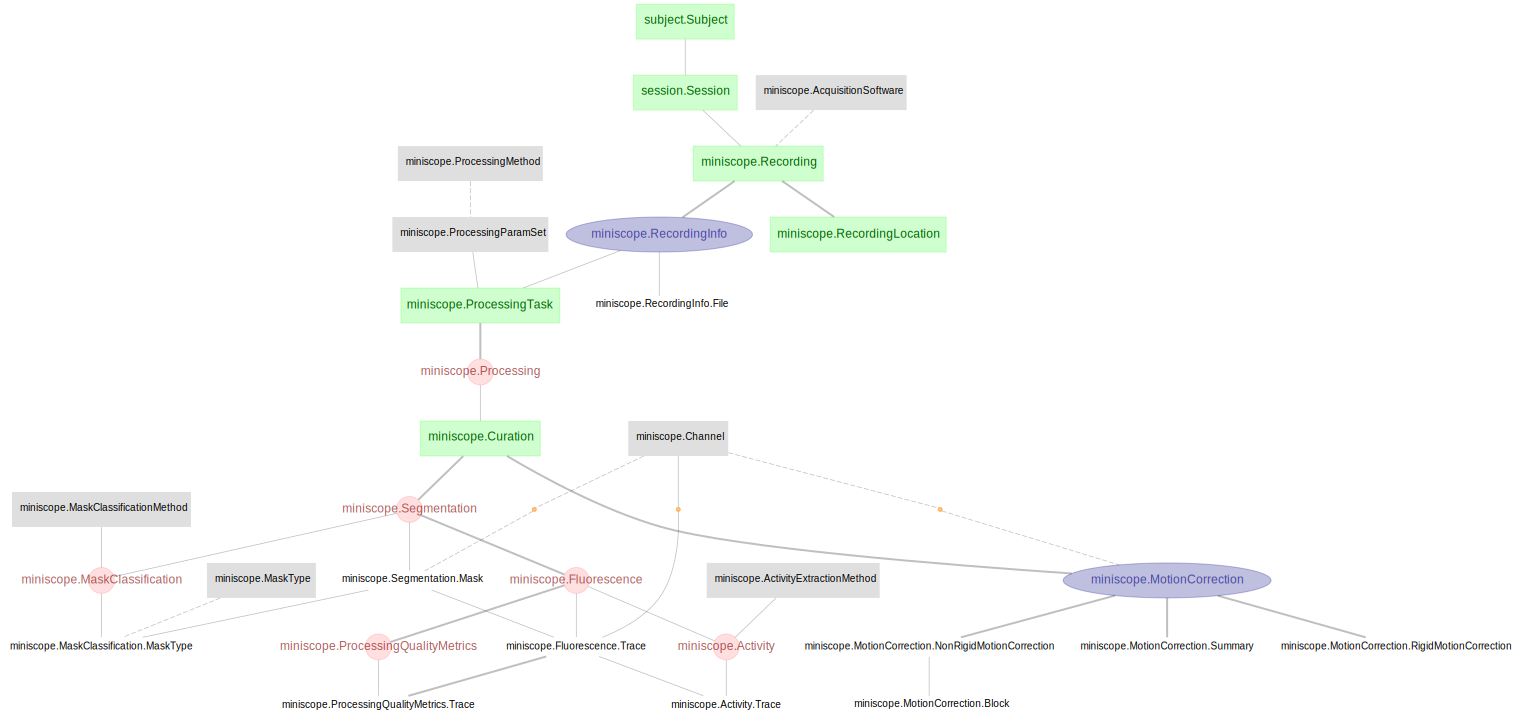

In [4]:
(dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(miniscope))

As evident from the diagram, this data pipeline encompasses tables associated with
recording-level (scan-level) metadata, image processing results, and optional curation
of image processing. A few tables such as `subject.Subject` or `session.Session` are
inherited from `element-animal` and `element-session`, respectively, and while important
for a complete pipeline, fall outside the scope of the `element-miniscope` tutorial and
will therefore, not be explored extensively here. The primary focus of this tutorial is
on the `miniscope` schema.

### **Insert subject and session metadata**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes
using the `.describe` and `.heading` methods.

In [5]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


In [6]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname=""  : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



In [7]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [8]:
subject.Subject.insert1(
    dict(subject="subject1", subject_birth_date="2023-01-01", sex="U")
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,U,2023-01-01,


Let's repeat the steps above for the `Session` table and see how the output varies between
`.describe` and `.heading`.

In [9]:
print(session.Session.describe())

-> subject.Subject
session_datetime     : datetime                     



In [10]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [11]:
session_key = dict(subject="subject1", session_datetime="2023-01-01 00:00:00")

In [12]:
session.Session.insert1(session_key)
session.Session()

subject,session_datetime
subject1,2023-01-01 00:00:00


Every experimental session produces a set of data files. The `SessionDirectory` table's
purpose is to locate these files. It references a directory path relative to a root
directory, defined in `dj.config["custom"]`. More
information about `dj.config` is provided in the [documentation](https://datajoint.com/docs/elements/user-guide/).

In [13]:
session.SessionDirectory.insert1(dict(**session_key, session_dir="session1"))
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject1,2023-01-01 00:00:00,session1


As the workflow diagram indicates, the first table in the `miniscope` schema is the `miniscope.Recording` table.

In [14]:
print(miniscope.Recording.describe())

-> session.Session
recording_id         : int                          
---
-> lab.Device
-> miniscope.AcquisitionSoftware
recording_notes=""   : varchar(4095)                # free-notes



In [15]:
miniscope.Recording.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
---
device               : varchar(32)                  # 
acq_software         : varchar(24)                  # 
recording_notes=""   : varchar(4095)                # free-notes

As you can see from the `describe()` method, this lab contains a dependency on the `Device` table within the `lab` schema. Let's quickly insert a miniscope device before inserting into `miniscope.Recording`. 

In [16]:
lab.Device.heading

# 
device               : varchar(32)                  # 
---
modality             : varchar(64)                  # 
description=""       : varchar(256)                 # 

In [17]:
lab.Device.insert1(dict(device="miniscope A", modality="miniscope"))

In [18]:
miniscope.Recording.insert1(
    dict(
        **session_key,
        recording_id=1,
        device="miniscope A",
        acq_software="Miniscope-DAQ-V4",
    )
)

### **Populate scan-level (recording-level) metadata**

In the upcoming cells, we'll make use of the `populate()` method to fill the `miniscope.RecordingInfo` table and its part table.

In [19]:
miniscope.RecordingInfo()

subject,session_datetime,recording_id,nchannels number of channels,nframes number of recorded frames,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,fps (Hz) frames per second,gain recording gain,"spatial_downsample e.g. 1, 2, 4, 8. 1 for no downsampling",led_power LED power used in the given recording,time_stamps time stamps of each frame,recording_datetime datetime of the recording,recording_duration (seconds) duration of the recording


In [20]:
miniscope.RecordingInfo.File()

subject,session_datetime,recording_id,file_id,file_path relative to root data directory


In [21]:
miniscope.RecordingInfo.populate(session_key, display_progress=True)

RecordingInfo: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Let's view the information was entered into each of these tables:

In [22]:
miniscope.RecordingInfo()

subject,session_datetime,recording_id,nchannels number of channels,nframes number of recorded frames,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,fps (Hz) frames per second,gain recording gain,"spatial_downsample e.g. 1, 2, 4, 8. 1 for no downsampling",led_power LED power used in the given recording,time_stamps time stamps of each frame,recording_datetime datetime of the recording,recording_duration (seconds) duration of the recording
subject1,2023-01-01 00:00:00,1,1,111770,600,600,nan,nan,20.0,2.0,1,5.0,=BLOB=,None,5588.5


In [23]:
miniscope.RecordingInfo.File()

subject,session_datetime,recording_id,file_id,file_path relative to root data directory
subject1,2023-01-01 00:00:00,1,0,session1/0.avi


### **Run Image Processing using CaImAn**

We're almost ready to perform image processing with `CaImAn`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
define the `CaImAn` parameters in a dictionary and insert them into a DataJoint table
`ProcessingParamSet`. This table keeps track of all combinations of your image
processing parameters. You can choose which parameters are used during processing in a
later step.

Let's view the attributes and insert data into `miniscope.ProcessingParamSet`.

In [24]:
miniscope.ProcessingParamSet.heading

# Parameter set used for processing of miniscope data
paramset_id          : smallint                     # 
---
processing_method    : varchar(16)                  # 
paramset_desc        : varchar(128)                 # 
param_set_hash       : uuid                         # 
params               : longblob                     # dictionary of all applicable parameters

In [25]:
params = dict(
    decay_time=0.4,
    pw_rigid=False,
    max_shifts=(5, 5),
    gSig_filt=(3, 3),
    strides=(48, 48),
    overlaps=(24, 24),
    max_deviation_rigid=3,
    border_nan="copy",
    method_init="corr_pnr",
    K=None,
    gSig=(3, 3),
    gSiz=(13, 13),
    merge_thr=0.7,
    p=1,
    tsub=2,
    ssub=1,
    rf=40,
    stride=20,
    only_init=True,
    nb=0,
    nb_patch=0,
    method_deconvolution="oasis",
    low_rank_background=None,
    update_background_components=True,
    min_corr=0.8,
    min_pnr=10,
    normalize_init=False,
    center_psf=True,
    ssub_B=2,
    ring_size_factor=1.4,
    del_duplicates=True,
    border_pix=0,
    min_SNR=3,
    rval_thr=0.85,
    use_cnn=False,
)


miniscope.ProcessingParamSet.insert_new_params(
    processing_method="caiman",
    paramset_id=0,
    paramset_desc="Miniscope analysis with CaImAn using default parameters",
    params=params,
)

Now that we've inserted kilosort parameters into the `ProcessingParamSet` table,
we're almost ready to run image processing. DataJoint uses a `ProcessingTask` table to
manage which `Recording` and `ProcessingParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [26]:
miniscope.ProcessingTask.heading

# Manual table marking a processing task to be triggered or manually processed
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
paramset_id          : smallint                     # 
---
processing_output_dir : varchar(255)                 # relative to the root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load existing results

The `ProcessingTask` table contains two important attributes: 
+ `paramset_id` 
+ `task_mode` 

The `paramset_id` attribute tracks
your `CaImAn` parameter sets. You can choose the parameter set that should be used for
image processing. For example, `paramset_id=0` may contain
default parameters for `CaImAn` processing whereas `paramset_id=1` contains your custom
parameters for motion correction. This
attribute tells the `Processing` table which set of parameters you are processing in a given `populate()`.

The `task_mode` attribute can be set to either `load` or `trigger`. When set to `load`,
running the processing step initiates a search for existing `CaImAn` output files. When set to `trigger`, the
processing step will run `CaImAn` on the raw data. 

In [27]:
miniscope.ProcessingTask.insert1(
    dict(
        **session_key,
        recording_id=1,
        paramset_id=0,
        task_mode="load",  # load or trigger
        processing_output_dir="session1/caiman",
    )
)

In [28]:
miniscope.Processing.populate(session_key, display_progress=True)

Processing:   0%|          | 0/1 [00:00<?, ?it/s]2023-11-29 17:33:06.617370: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 17:33:06.652351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 17:33:06.652396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 17:33:06.653638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 17:33:06.660101: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 17:33:06.660693: 

While image processing is completed in the above step, you can optionally curate
the output of image processing using the `Curation` table. For this demo, we
will simply use the results ingested from the `Processing` task.

In [29]:
miniscope.Curation.heading

# Different rounds of curation performed on the processing results of the data
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
paramset_id          : smallint                     # 
curation_id          : int                          # 
---
curation_time        : datetime                     # time of generation of these curated results
curation_output_dir  : varchar(255)                 # output directory of the curated results,
manual_curation      : tinyint                      # has manual curation been performed?
curation_note=""     : varchar(2000)                # 

In [30]:
processing_key = (miniscope.ProcessingTask & session_key).fetch1("KEY")
miniscope.Curation().create1_from_processing_task(processing_key)

Once the `Curation` table receives an entry, we can populate the remaining
tables in the workflow including `Segmentation`, `Fluorescence`, and `Activity`. 

In [31]:
miniscope.MotionCorrection.populate(session_key, display_progress=True)
miniscope.Segmentation.populate(session_key, display_progress=True)
miniscope.Fluorescence.populate(session_key, display_progress=True)
miniscope.Activity.populate(session_key, display_progress=True)

Activity: 100%|██████████| 2/2 [00:10<00:00,  5.37s/it]


Now that we've populated the tables in this workflow, there are one of
several next steps. If you have an existing workflow for
aligning waveforms to behavior data or other stimuli, you can easily
invoke `element-event` or define your custom DataJoint tables to extend the
pipeline.

### **Visualize the results.**

In this tutorial, we will do some exploratory analysis by fetching the data from the database and creating a few plots.

In [32]:
trace = (miniscope.Fluorescence.Trace & "mask = '10'").fetch1("fluorescence")

In the query above, we fetch a single fluorescence trace from the `fluorescence`
attribute in the `Trace` part table belonging to the `Fluorescence` table.
We also restrict the query to mask number 10.

Let's go ahead and fetch the sampling rate and plot the trace.

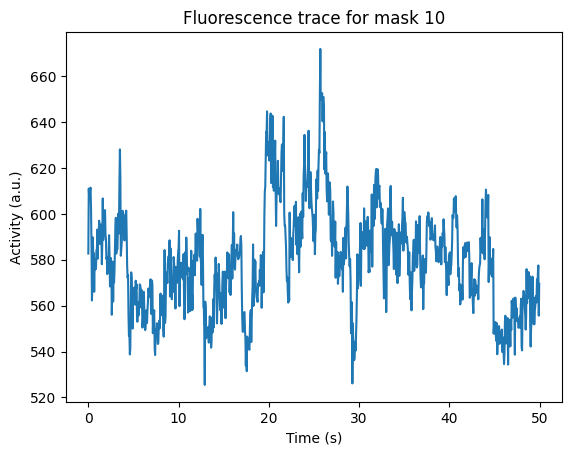

In [33]:
sampling_rate = (miniscope.RecordingInfo & session_key).fetch1("fps")

plt.plot(np.r_[: trace.size] * 1 / sampling_rate, trace)
plt.title("Fluorescence trace for mask 10")
plt.xlabel("Time (s)")
plt.ylabel("Activity (a.u.)");

DataJoint queries are a highly flexible tool to manipulate and visualize your data.
After all, visualizing traces or generating rasters is likely just the start of
your analysis workflow. This can also make the queries seem more complex at
first. However, we'll walk through them slowly to simplify their content in this notebook. 

The examples below perform several operations using DataJoint queries:
- Use **multiple restrictions** to fetch the average image generated during motion correction.
- Use a **join** operation and **multiple restrictions** to fetch x and y coordinates of
  masks generated during image segmentation.

In [34]:
average_image = (miniscope.MotionCorrection.Summary & session_key).fetch1(
    "average_image"
)

mask_xpix, mask_ypix = (
    miniscope.Segmentation.Mask * miniscope.MaskClassification.MaskType
    & session_key
    & "mask_npix > 50"
).fetch("mask_xpix", "mask_ypix")

The mask coordinates can be overlayed with the average image.

In [36]:
mask_image = np.zeros(np.shape(average_image[0, :, :]), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

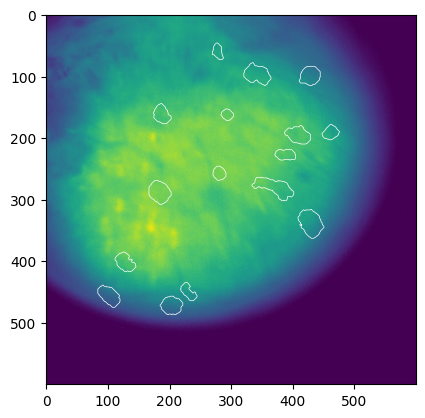

In [38]:
plt.imshow(average_image[0, :, :])
plt.contour(mask_image, colors="white", linewidths=0.5)

## Summary

Following this tutorial, we have:

+ Covered the essential functionality of `element-miniscope`.
+ Learned how to manually insert data into tables.
+ Executed and ingested results of image processing with `CaImAn`.
+ Visualized the results.

#### Documentation and DataJoint Tutorials

+ [Detailed documentation on
  `element-miniscope`.](https://datajoint.com/docs/elements/element-miniscope/)
+ [General `datajoint-python`
  tutorials.](https://github.com/datajoint/datajoint-tutorials) covering fundamentals,
  such as table tiers, query operations, fetch operations, automated computations with the
  make function, and more.
+ [Documentation for
  `datajoint-python`.](https://datajoint.com/docs/core/datajoint-python/)

##### Run this tutorial on your own data

To run this tutorial notebook on your own data, please use the following steps:
+ Download the [mysql-docker image for
  DataJoint](https://github.com/datajoint/mysql-docker) and run the container according
  to the instructions provide in the repository.
+ Create a fork of this repository to your GitHub account.
+ Clone the repository and open the files using your IDE.
+ Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code. 

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

+ Run the code block above and proceed with the rest of the notebook.